In [1]:
## Class that contains all the methods

import autograd.numpy as np
from autograd import grad
from numpy.polynomial.legendre import leggauss


class GLLquadrature:
    # Initialize the class
    def __init__(self, f, lb, ub, n = 20):
        self.f = f
        self.lb = lb
        self.ub = ub
        self.n = n
        
    # Compute the integral
    def compute(self):
        # Load nodes and weights in [-1,1]        
        x, w = leggauss(self.n)
        # Rescale nodes to [lb,ub]
        x = 0.5*(self.ub - self.lb)*(x + 1.0) + self.lb
        # Evaluate function at nodes        
        y = self.f(x)
        # Compute integral in [lb,ub]
        return 0.5*(self.ub-self.lb)*np.dot(y,w)
    

class TrapezoidalRule:
    # Initialize the class
    def __init__(self, f, lb, ub, n = 20):
        self.f = f
        self.lb = lb
        self.ub = ub
        self.n = n
     
    # Compute the integral
    def compute(self):
        x = np.linspace(self.lb, self.ub, self.n)
        dx = np.abs(x[1]-x[0])
        y = self.f(x)
        return dx*np.sum(y[1:-1]) + 0.5*dx*(y[0] + y[-1])
        
        
class CentralDifference:
    # Initialize the class
    def __init__(self, f, lb, ub, n = 100):
        self.f = f
        self.lb = lb
        self.ub = ub
        self.n = n
        
    def compute(self):
        # Create a uniform grid
        x = np.linspace(self.lb, self.ub, self.n)[:,None]
        y = self.f(x)
        dx = x[1]-x[0]
        
        # Create central difference matrix
        diagonals = [np.zeros((self.n,1)).flatten(), np.ones((self.n-1,1)).flatten(), -np.ones((self.n-1,1)).flatten()]
        A = np.diag(diagonals[0], k = 0) + np.diag(diagonals[1], k = 1) + np.diag(diagonals[2], k = -1)
        A[0,0:3] = np.array([-3.0, 4.0, -1.0]) # Left boundary
        A[-1,-3:] = np.array([1.0, -4.0, 3.0]) # Right boundarya
        A = A/(2.0*dx)
        self.A = A
        
        return np.matmul(A, y)
        

class LagrangeInterpolant:
    # Initialize the class
    def __init__(self, x_star, x, y):
        self.x_star = x_star
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.Phi = np.zeros((y.shape[0], x_star.shape[0]))
        
    # Fit the Lagrange interpolating polynomial
    def fit(self):
        for k in range(0,self.n):
            prod = np.ones_like(self.x_star)
            for j in range(0,self.n):
                if k!=j:
                    prod *= (self.x_star - self.x[j])/(self.x[k] - self.x[j])
            self.Phi[k,:] = prod
        return np.matmul(self.Phi.T, self.y)
    
    

In [2]:
# Question 1.

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)
    
if __name__ == "__main__":
    
    def sample_SPD_matrix(n):
        Q = np.random.randn(n,n)
        eigen_mean = 1
        D = np.diag(np.abs(eigen_mean+np.random.randn(n,1)).flatten())
        A = np.matmul(Q.T, np.matmul(D,Q))
        return A
    
    def power_iteration(A, num_iter):
        # Ideally choose a random vector
        # To decrease the chance that our vector
        # Is orthogonal to the eigenvector
        b_k = np.random.randn(A.shape[0],1)
        eigen = np.zeros((num_iter,1))
        for i in range(num_iter):
            # calculate the matrix-by-vector product Ab
            b_k1 = np.matmul(A, b_k)
    
            # calculate the norm
            b_k1_norm = np.linalg.norm(b_k1)
    
            # re normalize the vector
            b_k = b_k1 / b_k1_norm
            
            # compute the eignevalue
            e_k = np.matmul(b_k.T, np.matmul(A, b_k))/np.matmul(b_k.T, b_k)
            
            eigen[i,0] = e_k
            
        return e_k, b_k, eigen
    
    N = 200 
    nIter = 1000
    
    A = sample_SPD_matrix(N)
    
    c = np.linalg.cond(A)   
    w, v = np.linalg.eig(A)
    ww, vv, eigen_max = power_iteration(A, nIter)
    
    print('Condition number of A: %e' % (c))
    print('Largest eigenvalue A (eig): %e' % (w.max()))
    print('Largest eigenvalue A (power): %e' % (ww))
    
    B = A - ww*np.eye(N)
    c = np.linalg.cond(B)   
    www, vvv, eigen_min = power_iteration(B, nIter)
    
    print('Condition number of A - lambda_max*I: %e' % (c))
    print('Smallest eigenvalue A (eig): %e' % (w.min()))
    print('Smallest eigenvalue A (power): %e' % (www + ww))
    
    minim = eigen_min+eigen_max
    iterations = np.arange(0,nIter)
    
    fig222 = plt.figure(222)
    ax222 = fig222.add_subplot(111)
    ax222.plot(iterations, eigen_max.flatten(), 'r-')
    ax222.set_xlabel("Iterations")
    ax222.set_ylabel("Max Eigenvalue per iteration")
    
    fig333 = plt.figure(333)
    ax333 = fig333.add_subplot(111)
    
    ax333.plot(iterations, minim, 'r-')
    ax333.set_xlabel("Iterations")
    ax333.set_ylabel("Min Eigenvalue per iteration")
           

Condition number of A: 3.863999e+06
Largest eigenvalue A (eig): 1.252895e+03
Largest eigenvalue A (power): 1.252895e+03
Condition number of A - lambda_max*I: 1.794409e+16
Smallest eigenvalue A (eig): 3.242483e-04
Smallest eigenvalue A (power): 5.537733e-01


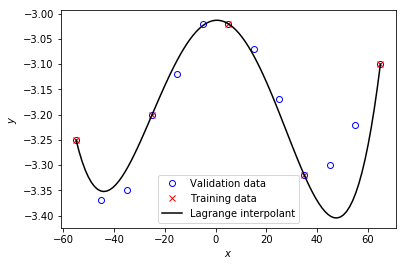

In [3]:
# Question 2.

from Methods import LagrangeInterpolant

if __name__ == '__main__':
    
    # Load training data
    training_data = np.loadtxt('HW2_training_data.txt')
    x_t = training_data[:,0:1]
    y_t = training_data[:,1:2]
    
    # Load validation data
    validation_data = np.loadtxt('HW2_validation_data.txt')
    x_v = validation_data[:,0:1]
    y_v = validation_data[:,1:2]
    
    # Create a grid to plot the predicted function
    x_star = np.linspace(x_v.min(0), x_v.max(0), 100)
    
    # Construct the Lagrange interpolant
    model = LagrangeInterpolant(x_star, x_t, y_t)
    y_pred = model.fit()
    
    # Plot the results
    plt.figure(1)
    plt.plot(x_v, y_v,'bo', markerfacecolor = 'None', label = "Validation data")
    plt.plot(x_t, y_t,'rx', label = "Training data")
    plt.plot(x_star, y_pred, 'k-', label = "Lagrange interpolant")
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()
    
       
    

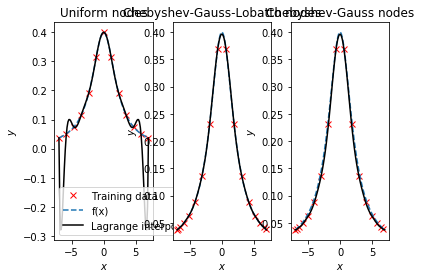

In [4]:
# Question 3.

from Methods import LagrangeInterpolant

if __name__ == '__main__':
     
    def f(x):
        return 2.0/(5.0+x**2)
    
    # Load training data
    N = 17
    lb = -7.0
    ub  = 7.0
      
    # Training data (uniform nodes)
    x_u = np.linspace(lb,ub,13)[:,None]
    y_u = f(x_u)
    
    # Training data (Chebyshev-Gauss-Lobatto nodes)
    x_i = -np.cos(np.pi*np.arange(0,N)/N)[:,None]    
    x_cgl = 0.5*(lb+ub) + 0.5*(ub-lb)*x_i
    y_cgl = f(x_cgl)
    
    # Training data (Chebyshev-Gauss nodes)
    x_i = np.cos(0.5*np.pi*((2.0*np.arange(0,N) + 1.0)/(N+1)))[:,None]    
    x_cg = 0.5*(lb+ub) - 0.5*(ub-lb)*x_i
    y_cg = f(x_cgl)
    
    # Create a grid to plot the predicted function
    x_star = np.linspace(lb, ub, 100)
    
    # Construct the Lagrange interpolant
    m1 = LagrangeInterpolant(x_star, x_u, y_u) 
    m2 = LagrangeInterpolant(x_star, x_cgl, y_cgl)
    m3 = LagrangeInterpolant(x_star, x_cg, y_cg)
    
    y_pred_u   = m1.fit()
    y_pred_cgl = m2.fit()
    y_pred_cg  = m3.fit()

    # Plot the results
    plt.figure(1)
    plt.subplot(1,3,1)
    plt.plot(x_u, y_u,'rx', label = "Training data")
    plt.plot(x_star, f(x_star), '--', label = "f(x)")
    plt.plot(x_star, y_pred_u, 'k-', label = "Lagrange interpolant")
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Uniform nodes')
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(x_cgl, y_cgl,'rx', label = "Training data")
    plt.plot(x_star, f(x_star), '--', label = "f(x)")
    plt.plot(x_star, y_pred_cgl, 'k-', label = "Lagrange interpolant")
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Chebyshev-Gauss-Lobatto nodes')
    
    plt.subplot(1,3,3)
    plt.plot(x_cg, y_cg,'rx', label = "Training data")
    plt.plot(x_star, f(x_star), '--', label = "f(x)")
    plt.plot(x_star, y_pred_cg, 'k-', label = "Lagrange interpolant")
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Chebyshev-Gauss nodes')
    
    

    
    
    
       
    

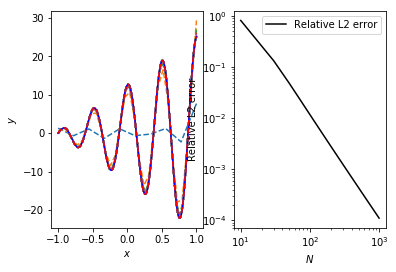

In [5]:
# Question 4.

import autograd.numpy as np
from autograd import elementwise_grad as egrad

from Methods import CentralDifference

if __name__ == '__main__':
    
    def f(x):
        return (x+1)*np.sin(4.0*np.pi*x)
    
    N = np.arange(10,1000,20)
    lb = -1.0
    ub = 1.0
    grad_f = egrad(f)
    
    error = []
    pred = []
    x_grid = []
    for i in range(0, N.shape[0]):
        # Fit a central difference approximation
        model = CentralDifference(f, lb, ub, N[i])
        df_dx_pred = model.compute()
        pred.append(df_dx_pred)
    
        # Create a grid for testing the accuracy
        x_star = np.linspace(lb, ub, N[i])[:,None]
        y_star = grad_f(x_star)
        e = np.linalg.norm(y_star - pred[i], 2)/np.linalg.norm(y_star, 2)
        error.append(e)
        x_grid.append(x_star)
        
    # Plot
    fig = plt.figure(1)
    ax1 = fig.add_subplot(1, 2, 1)
    for i in range(0, N.shape[0]-1):
        ax1.plot(x_grid[i], pred[i], '--')
    ax1.plot(x_grid[-1], grad_f(x_grid[-1]), 'b', label = "Exact solution")
    ax1.plot(x_grid[-1], pred[-1], 'r--', label = "Approximation")        
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    
     
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(N, error, 'k-', label = "Relative L2 error")
    ax2.set_xlabel('$N$')
    ax2.set_ylabel('Relative L2 error')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    plt.legend()
   


    

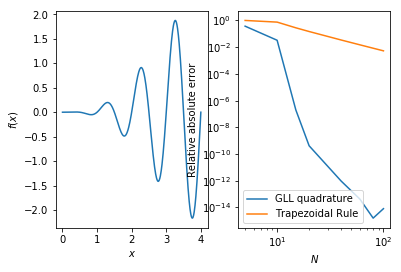

In [6]:
# Question 5.

import scipy.special as special

from Methods import GLLquadrature, TrapezoidalRule

if __name__ == '__main__':
    
    def f(x):
        return (x+1.0) * np.sin(2.0*np.pi*x) * special.jv(2.5,x)
    
    N=np.array([5,10,15,20,40,60,80,100])
    lb = 0.0
    ub = 4.0
    
    # Ground truth    
    model = GLLquadrature(f, lb, ub, 200)
    I_exact = model.compute()
    
    error_gll = []
    error_trap = []
    for i in range(0, N.shape[0]):
        m1 = GLLquadrature(f, lb, ub, N[i])
        m2 = TrapezoidalRule(f, lb, ub, N[i])
        I_gll = m1.compute()
        I_trp = m2.compute()
        e_gll = np.abs(I_exact - I_gll)/np.abs(I_exact)
        e_trp = np.abs(I_exact - I_trp)/np.abs(I_exact)
        error_gll.append(e_gll)
        error_trap.append(e_trp)
         
    fig = plt.figure(1)
    ax = fig.add_subplot(121)
    x_star = np.linspace(lb, ub, 500)
    ax.plot(x_star, f(x_star))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax = fig.add_subplot(122)
    ax.plot(N, error_gll, label = "GLL quadrature")
    ax.plot(N, error_trap, label = "Trapezoidal Rule")
    ax.set_xlabel('$N$')
    ax.set_ylabel('Relative absolute error')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend()